# Generate Synthetic Data

In [1]:
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import SimParams, OptimizationParameters
from act.cell_model import TargetCell, ModuleParameters

random_seed = 47
num_slices = 10
module_name = f"spiker_seg_sl-{num_slices}/{random_seed}"
module_name = "output/" + module_name

target_cell = TargetCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Spiker/seg/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Spiker/seg",
    cell_name="Simple_Spiker_seg",
    g_names = ["gnabar_hh_seg", "gkbar_hh_seg", "gl_hh_seg"]
)

sim_par= SimParams(
            h_v_init=-65.0,  # Consistent with nrngui settings
            h_tstop=500,     # Simulation time in ms
            h_dt=0.1,      # Time step in ms
            h_celsius=6.3,   # Temperature in degrees Celsius
            CI_type="constant",
            CI_amps=[0.1,0.2,0.3],   # Current injection amplitude
            CI_dur=300,      # Duration of current injection
            CI_delay=100,     # Delay before current injection
            set_g_to=[]
        )

sg = SyntheticGenerator(
    ModuleParameters(
        module_folder_name=module_name,
        cell= target_cell,
        sim_params= sim_par,
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg.generate_synthetic_target_data("target_data.csv")

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.


Blocking: []
Total number of jobs: 3
Total number of proccessors: 192
/home/mwsrgf/proj/ACT/output/spiker_seg_sl-10/46/synthetic_0.1_0.2_0.3_


In [2]:
passive_sim_par = SimParams(
            h_v_init = -65,
            h_tstop = 500,
            h_dt = 0.1,
            h_celsius = 6.3,
            CI_type = "constant",
            CI_amps = [-0.1],    ##################### NEGATIVE CURRENT INJECTION ###################
            CI_dur = 300,
            CI_delay = 100,
            set_g_to=[]
        )

sg_passive = SyntheticGenerator(
    ModuleParameters(
        module_folder_name=module_name,
        cell= target_cell,
        sim_params= passive_sim_par,
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg_passive.generate_synthetic_target_data("passive_data.csv")

Blocking: []
Total number of jobs: 1
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/output/spiker_seg_sl-10/46/synthetic_-0.1_


# Get Passive Properties

In [3]:
from act.PassivePropertiesModule import PassivePropertiesModule
from act.act_types import SimParams
from act.cell_model import TrainCell

train_cell = TrainCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Spiker/seg/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Spiker/seg",
    cell_name="Simple_Spiker_seg",
    g_names = ["gnabar_hh_seg", "gkbar_hh_seg", "gl_hh_seg"]
)

passive_mod = PassivePropertiesModule(
    train_cell=train_cell,
    sim_params=passive_sim_par,
    trace_filepath=f"{module_name}/target/passive_data.csv",
    leak_conductance_variable="gl_hh_seg",
    leak_reversal_variable="el_hh_seg"
)

In [4]:
passive_mod.set_passive_properties()
print(train_cell.passive_properties)

MECHANISMS already loaded.
Found 1 section(s) in this cell. Calculating the total surface area of the cell.
PassiveProperties(V_rest=-65.0, R_in=191.99802919980584, tau=2.7, Cm=1.2664890000000124, g_bar_leak=0.00046907000000000453, cell_area=1.1103645074847766e-05, leak_conductance_variable='gl_hh_seg', leak_reversal_variable='el_hh_seg')


# Run Original Pipeline with Passive Prediction

In [5]:
from act.ACTModule import ACTModule
from act.act_types import OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters

mod = ACTModule(
    ModuleParameters(
        module_folder_name=module_name,
        cell= train_cell,
        target_traces_file = "target_data.csv",
        sim_params= sim_par,
        optim_params= OptimizationParameters(
            g_ranges_slices= [
                OptimizationParam(param="gnabar_hh_seg", low=0.06, high=0.18, n_slices=num_slices),
                OptimizationParam(param="gkbar_hh_seg", low=0.018, high=0.054, n_slices=num_slices),
                OptimizationParam(param="gl_hh_seg", prediction=train_cell.passive_properties.g_bar_leak, bounds_variation=0.0, n_slices=1),
                
            ],
            list_of_features=["i_trace_stats", "v_trace_stats"],
            prediction_eval_method='fi_curve',
            random_state=random_seed,
            save_file=f"{module_name}/results/saved_metrics.json"
        )
    )
)

In [6]:
predicted_g_data_file = mod.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA
Total number of jobs: 300
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/output/spiker_seg_sl-10/46/train
TRAINING RANDOM FOREST REGRESSOR
Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Interspike Interval 1', 'Interspike Interval 2', 'Interspike Interval 3', 'Interspike Interval 4', 'Interspike Interval 5', 'Interspike Interval 6', 'Interspike Interval 7', 'Interspike Interval 8', 'Interspike Interval 9', 'Interspike Interval 10', 'Interspike Interval 11', 'Interspike Interval 12', 'Interspike Interval 13', 'Interspike Interval 14', 'Interspike Interval 15', 'Interspike Interval 16', 'Interspike Interval 17', 'Interspike Interval 18', 'Interspike Interval 19', 'Min Spike Height', 'Max Spike Height', 'Avg Spike Height', 'Std Spike Height', 'Mean Voltage', 'Std Voltage']
Evaluating random forest
MAE: 0.003362 (0.000456)
Saving rf mean/stdev scores to output/spiker_seg_sl-10/46

In [7]:
mod.pickle_rf(mod.rf_model,f"{module_name}/trained_rf.pkl")

# Closer Look

In [8]:
from act import ACTPlot
ACTPlot.plot_v_comparison(
    predicted_g_data_file, 
    module_name, 
    sim_par["CI_amps"]
    )

ACTPlot.plot_fi_comparison(
    module_name, 
    sim_par["CI_amps"]
    )

In [9]:
from act.Metrics import Metrics

metrics = Metrics()

mean, stdev = metrics.print_interspike_interval_comparison(
    module_name,
    predicted_g_data_file,
    sim_par["CI_amps"], 
    sim_par["h_dt"],
    first_n_spikes=5,
    save_file=f"{module_name}/results/saved_metrics.json"
)

metrics.print_prediction_g_mae(
    actual_g={'gnabar_hh_seg': 0.12, 'gkbar_hh_seg': 0.036, 'gl_hh_seg': 0.00046907},
    save_file=f"{module_name}/results/saved_metrics.json"
)

Interspike times (Target): [[12.4 12.  11.9 12. ]
 [11.1 10.7 10.6 10.7]
 [10.5 10.   9.9 10. ]]
Interspike times (Prediction): [[12.2 11.9 11.9 11.8]
 [11.  10.5 10.5 10.5]
 [10.4  9.8  9.8  9.8]]
MAE for each I injection: [0.125, 0.14999999999999858, 0.14999999999999858]
Mean interspike-interval MAE: 0.14166666666666572
Standard Deviation interspike-interval MAE: 0.011785113019775122
MAE of final g prediction: 0.0013879999999996714


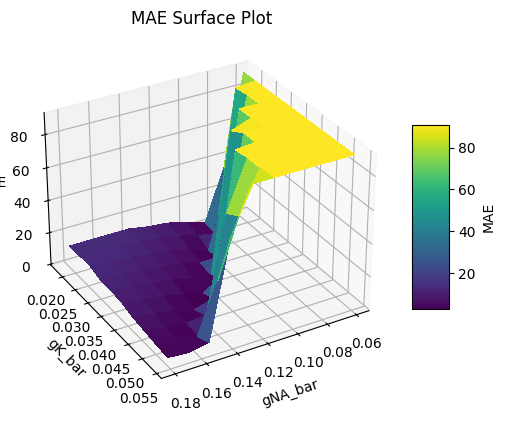

In [10]:
from act import ACTPlot as actplt

actplt.plot_training_fi_mae_surface_spiker_cell(
module_name,
sim_par["CI_amps"],
sim_par["CI_dur"],
sim_par["CI_delay"],
sim_par["h_dt"],
f"{module_name}/results/FI_MAE_Surface.html",
)

Smallest MAE values (gNa, gK, MAE): 
[[0.1        0.026      1.11111111]
 [0.14       0.042      1.11111111]
 [0.12666667 0.038      1.11111111]
 [0.11333333 0.034      2.22222222]
 [0.15333333 0.05       2.22222222]
 [0.08666667 0.022      2.22222222]]


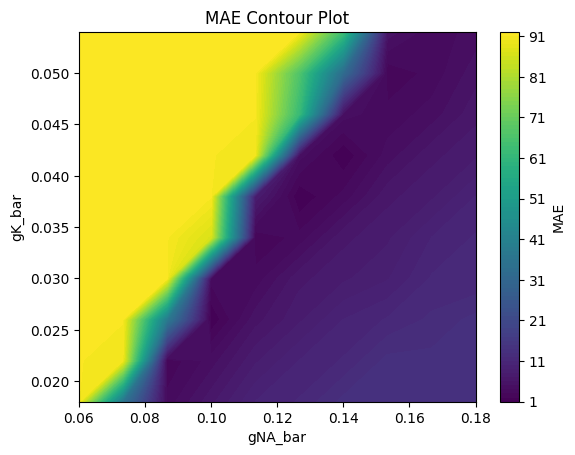

In [11]:
from act import ACTPlot as actplt

actplt.plot_training_fi_mae_contour_plot(
module_name,
sim_par["CI_amps"],
sim_par["CI_dur"],
sim_par["CI_delay"],
sim_par["h_dt"],
num_levels=100,
results_filename=f"{module_name}/results/contour_plot.png"
)

found indices: 100
found indices: 100
found indices: 100


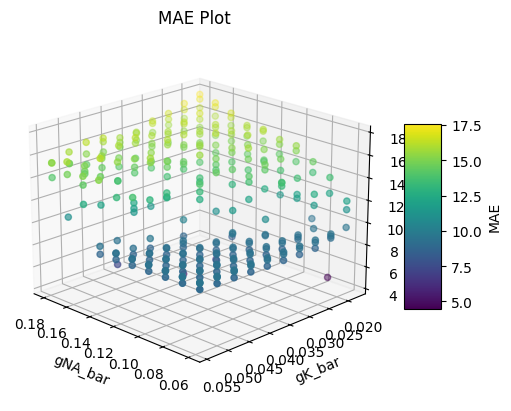

In [12]:
from act import ACTPlot as actplt

actplt.plot_training_v_mae_scatter_spiker_cell(
    module_name,
    sim_par['CI_delay'],
    sim_par['h_dt']
)